In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.engine.input_layer import Input
from keras.applications import ResNet50
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Lambda, Reshape
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import os, glob
import numpy as np
import pandas as pd
import cv2


img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
path = '/content/gdrive/My Drive/car_classifier/dataset/'
batch_size = 64
nb_train_samples = 5999
nb_validation_samples = 165
epochs = 20

## Mount and Load Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    )

test_datagen = ImageDataGenerator(
    rescale=1./255,
    )

In [10]:
train_generator = train_datagen.flow_from_directory(
    path + 'train/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input')

Found 5999 images belonging to 1 classes.


In [11]:
validation_generator = test_datagen.flow_from_directory(
    path + 'test/',
    target_size=(img_height, img_width),
    batch_size=256,
    class_mode='input')

Found 165 images belonging to 1 classes.


In [12]:
X_test = next(validation_generator)[0]
X_test.shape

(165, 224, 224, 3)

## Autoencoders

In [26]:
input = Input(shape=input_shape)

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) 
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
encoded = MaxPooling2D((2, 2), padding='same')(conv4)

# Decoder
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
conv5 = UpSampling2D((2, 2))(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
up1 = UpSampling2D((2,2))(conv6) 
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
up2 = UpSampling2D((2,2))(conv7)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(input, decoded)

autoencoder.compile(optimizer='adadelta',                      # optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
                    loss='mean_squared_error')      # mean_squared_error

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_29 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
batch_normalization_30 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 112, 112, 32)      4640      
__________

In [0]:
reduceLr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, mode='auto', cooldown=0, min_lr=0)
checkpoint = ModelCheckpoint(path + 'anomaly.h5', monitor='loss', verbose=0, save_best_only=True, mode='auto')

## Fit

In [20]:
autoencoder.fit_generator(
                    train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=3,
                    callbacks=[reduceLr, checkpoint]
                    )

Epoch 1/20
93/93 [==============================] - 53s 572ms/step - loss: 0.0192 - val_loss: 0.0244
Epoch 2/20
93/93 [==============================] - 47s 504ms/step - loss: 0.0106 - val_loss: 0.0147
Epoch 3/20
93/93 [==============================] - 48s 512ms/step - loss: 0.0091 - val_loss: 0.0125
Epoch 4/20
93/93 [==============================] - 48s 518ms/step - loss: 0.0084 - val_loss: 0.0109
Epoch 5/20
93/93 [==============================] - 49s 523ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 6/20
93/93 [==============================] - 49s 529ms/step - loss: 0.0075 - val_loss: 0.0099
Epoch 7/20
93/93 [==============================] - 49s 529ms/step - loss: 0.0072 - val_loss: 0.0091
Epoch 8/20
93/93 [==============================] - 49s 531ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 9/20
93/93 [==============================] - 49s 531ms/step - loss: 0.0069 - val_loss: 0.0085
Epoch 10/20
93/93 [==============================] - 50s 533ms/step - loss: 0.0066 - val_lo

## Prediction & Visualize

In [0]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def IsImageAnomalous(autoencoder, filePath,threshold):  
    im = cv2.resize(cv2.imread(filePath), (224, 224))       # cv2.imread(filePath)
    im = im * 1./255
    im = np.expand_dims(im, axis=0)
    validation_image = im;
    predicted_image = autoencoder.predict(validation_image)
    _mse = mse(predicted_image[0], validation_image) 
    print('_mse: {}'.format(_mse))
    return _mse  > threshold

In [0]:
autoencoder = load_model(path + 'anomaly.h5')

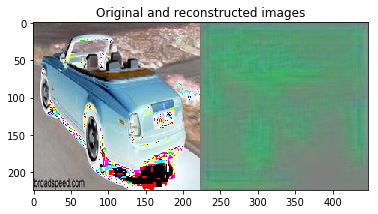

In [29]:
example1 = path + 'test/car/00006.jpg'
example2 = path + 'test/car/00135.jpg'
img = cv2.imread(example1)
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0)

dec = autoencoder.predict(img)
img = img[0]
dec = dec[0]
img = (img*255).astype('uint8')
dec = (dec*255).astype('uint8')

plt.imshow(np.hstack((img, dec)))
plt.title('Original and reconstructed images')
plt.show()

In [0]:
all_mses=[]
step=1;
for validation_image in validation_generator:   
    if step>nb_validation_samples:
        break;
        
    print(step, sep=' ', end='>', flush=True)
    predicted_image = autoencoder.predict(validation_image[0])
    mse_value= mse(predicted_image[0], validation_image[0])
    all_mses.append(mse_value)
    step=step+1

1>2>3>4>5>6>7>8>9>10>11>12>13>14>15>16>17>18>19>20>21>22>23>24>25>26>27>28>29>30>31>32>33>34>35>36>37>38>39>40>41>42>43>44>45>46>47>48>49>50>51>52>53>54>55>56>57>58>59>60>61>62>63>64>65>66>67>68>69>70>71>72>73>74>75>76>77>78>79>80>81>82>83>84>85>86>87>88>89>90>91>92>93>94>95>96>97>98>99>100>101>102>103>104>105>106>107>108>109>110>111>112>113>114>115>116>117>118>119>120>121>122>123>124>125>126>127>128>129>130>131>132>133>134>135>136>137>138>139>140>141>142>143>144>145>146>147>148>149>150>151>152>153>154>155>156>157>158>159>160>161>162>163>164>165>

In [0]:
error_df = pd.DataFrame({'reconstruction_error':all_mses})
error_df.describe()

,reconstruction_error
count,165.000000
mean,56.995205
std,11.734936
min,36.664061
25%,49.556466
50%,56.336609
75%,62.355697
max,95.021124


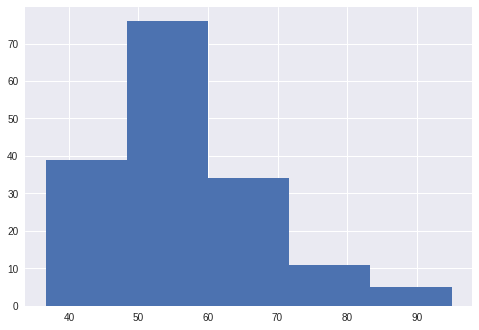

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)

_ = ax.hist(error_df.reconstruction_error.values, bins=5)

In [0]:
example1 = path + 'test/car/00009.jpg'
example2 = path + 'test/car/00120.jpg'

IsImageAnomalous(autoencoder, example2, threshold=0.1)

_mse: 0.018275186226964005


False

In [0]:
pred = []
for file in glob.glob(path + 'test/car/*.jpg'):
  predi = IsImageAnomalous(autoencoder, file, threshold=0.1)
  pred.append(predi)